<a href="https://colab.research.google.com/github/prosvirinKir/rzd/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyreadr

     |████████████████████████████████| 419kB 13.1MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import pyreadr
from tqdm.notebook import tqdm, trange

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
df = pyreadr.read_r("/content/gdrive/MyDrive/DLS/hw_segmentation/GOR.rds")

In [9]:
df = df[None]
df = df.loc[:, (df != df.iloc[0]).any()] 
df = df.drop(df[df.TARGET_2 < 0].index)
pd.set_option("display.max_columns", 200)
df = df.drop(["KODOTS", "RASHIFROVKA", "PROVERENO", "PLUS", "STATUS", "CATEGORY", "KODNAPR", "UPDATTR", "TARGET_1", "TARGET_3"], axis=1)
df["AVG_BALL"] = df["AVG_BALL"].str.replace(',', '.')
df["AVG_KILO"] = df["AVG_KILO"].str.replace(',', '.')
df = df.drop(["LINE"], axis=1)
df = df.drop(['X2179_3', 'X2179_4', 'X2195_3', 'X2195_4', 'X2221_4'], axis = 1)

In [10]:
# df_saved = df.copy()

In [7]:
# df = df_saved.copy()

### Дальше нормализуем

In [11]:
# Normalization

target = df['TARGET_2']
df_columns = df.columns

min_max_scaler = preprocessing.MinMaxScaler()
df.loc[:, :] = min_max_scaler.fit_transform(df)
df['TARGET_2'] = target.values

In [12]:
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)
df

,PCH,YEAR,MONTH,DAY,KM,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,LENGTH_KILO,RIX2,RIX3,RIX4,USH2,USH3,USH4,SUG2,SUG3,SUG4,PLU2,PLU3,PLU4,PER2,PER3,PER4,PRO2,PRO3,PRO4,OTS2,OTS3,OTS4,UKL,DRU,AVG_BALL,AVG_KILO,X2049_3,X2049_4,X2065_1,X2065_2,X2065_3,X2065_4,X2067_2,X2067_3,X2067_4,X2081_1,X2081_2,X2081_3,X2081_4,X2097_2,X2097_3,X2097_4,X2113_2,X2113_3,X2113_4,X2129_1,X2129_2,X2129_3,X2129_4,X2145_1,X2145_2,X2145_3,X2145_4,X2161_1,X2161_2,X2161_3,X2161_4,X2177_4,X2193_4,X2209_4,X2211_3,X2211_4,X2213_4,X2215_4,X2218_4,X2221_3,X2222_3,X2222_4,X2223_3,X2223_4,X2226_3,X2226_4,X2227_3,X2227_4,X2228_3,X2228_4,X2229_3,X2229_4,X2230_4,X2231_4,X2232_4,X2233_4,X2243_4,X2244_4,X2246_4,X2289_3,X2289_4,X2290_3,X2290_4,X2291_3,X2291_4,X3199_3,X3312_3,X3313_3,MISTAKES_GROUP,SPEED_RES_PAS_O,SPEED_RES_FRE_O,SPEED_NORM_PAS_O,SPEED_NORM_FRE_O,KR,DZ,T.,Z,IS,UR.PR,PRZH,X.,STRELKA,OBK,MOST,NR,ISM,PR_PREDUPR,EXCLUDE,TARGET_2,DIF_PAS_SP,DIF_FRE_SP,REPAIR_1,REPAIR_2,O_1,O_2,O_3,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,0.0,0.0,0.000000,0.600000,0.003185,0.0,0.000000,1.0,1.0,1.0,0.3,0.555556,0.326879,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.005291,0.0,0.0,0.0,0.0,0.000000,0.499749,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.06,0.030612,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,1.0,1.0,0.5,0.5,0.000000,0.005208,0.000000,0.0,0.005128,0.894454,0.978452,0.99403,0.935393,0.896057,0.89356,0.990089,0.853242
1,0.0,0.0,0.000000,0.733333,0.079618,0.0,0.000000,1.0,1.0,1.0,0.7,1.000000,0.327535,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.500753,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,1.0,1.0,0.14,0.071429,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.015873,0.000,0.0,0.0,0.0,0.004902,0.0,0.015873,0,1.0,1.0,0.5,1.0,0.000000,0.000000,0.006803,0.0,0.005128,0.892665,0.978452,0.99403,0.935393,0.894265,0.89356,0.990089,0.851536
2,0.0,0.0,0.000000,0.733333,0.081529,0.0,0.000000,1.0,1.0,1.0,0.8,1.000000,0.328192,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.501756,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,1.0,1.0,0.5,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.891771,0.978452,0.99403,0.935393,0.893369,0.89356,0.990089,0.850683
3,0.0,0.0,0.000000,0.733333,0.082803,0.0,0.000000,1.0,1.0,1.0,0.8,1.000000,0.326223,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.498746,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,

### Отбор признаков

PCA

In [18]:
RESULT_FEATURE_NUM = 20

In [19]:
df_pca = df.drop(['TARGET_2', 'DAY', 'YEAR'], axis=1).copy()
pca_values = PCA(n_components=RESULT_FEATURE_NUM).fit_transform(df_pca.values)
df_pca = pd.DataFrame(pca_values)

In [20]:
df_pca['DAY'] = df['DAY']
df_pca['MONTH'] = df['MONTH']
df_pca['YEAR'] = df['YEAR']
df_pca['KM'] = df['KM']
df_pca['TARGET_2'] = df['TARGET_2']

In [21]:
df_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,DAY,MONTH,YEAR,KM,TARGET_2
0,-0.272544,-0.246019,-0.564300,-0.078993,0.285489,-0.234712,-0.067946,0.035556,-0.042173,-0.235348,0.366814,-0.045144,0.056742,-0.043861,-0.077853,0.040354,0.008119,-0.012664,0.002662,-0.008268,0.600000,0.000000,0.0,0.003185,0
1,-0.419410,-0.168065,-0.451503,-0.077379,0.245502,0.110318,-0.417372,0.027256,0.015235,0.121839,-0.045707,-0.007840,-0.006935,-0.008032,0.005710,-0.018624,-0.010965,0.000096,0.017752,0.018528,0.733333,0.000000,0.0,0.079618,0
2,-0.386077,1.067979,-0.435094,0.112900,0.163002,0.235738,-0.368108,0.096463,0.085752,0.096625,-0.128574,0.000527,-0.016095,0.003484,0.023537,-0.023661,-0.001415,0.009017,-0.004228,0.023815,0.733333,0.000000,0.0,0.081529,0
3,-0.247574,1.096450,-0.508567,0.102474,0.136279,-0.184235,-0.155413,0.129693,0.078852,0.069258,-0.139509,0.002794,-0.021208,0.009208,0.021342,-0.026407,-0.004488,0.007400,-0.000574,0.019206,0.733333,0.000000,0.0,0.082803,0
4,-0.247612,1.096368,-0.508247,0.102572,0.135100,-0.184213,-0.155321,0.129470,0.078650,0.069341,-0.139532,0.002809,-0.021251,0.009206,0.021522,-0.026423,-0.004510,0.007410,-0.000582,0.019203,0.733333,0.000000,0.0,0.084076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107592,2.495602,-0.322433,-0.420414,-0.085109,0.385958,0.285405,0.457391,-0.245313,-0.066334,0.214308,-0.113315,0.005957,0.010480,-0.016596,0.016413,-0.006430,0.024096,0.013053,-0.013896,-0.003165,0.733333,0.454545,1.0,0.016561,0
107593,2.495065,-0.336899,-0.416664,-0.066283,0.376042,0.300071,0.473152,-0.183769,-0.071325,0.172131,-0.161424,0.072962,0.075785,-0.016358,0.024845,-0.002042,0.040558,0.011837,-0.022668,-0.033808,0.733333,0.454545,1.0,0.017834,0
107594,2.495335,-0.332785,-0.418999,-0.075721,0.375140,0.296315,0.470747,-0.219785,-0.035706,0.181966,-0.128247,0.073186,0.025889,0.004793,0.023637,0.010610,0.018182,0.023377,-0.004402,-0.027630,0.733333,0.454545,1.0,0.019108,0
107595,2.495322,-0.334254,-0.417186,-0.067743,0.376336,0.299366,0.472390,-0.203258,-0.071170,0.168054,-0.145858,0.055820,0.009804,0.026158,0.014785,-0.008542,0.007234,0.030373,-0.037054,0.030261,0.733333,0.454545,1.0,0.021019,0


TSNE

In [22]:
# RESULT_FEATURE_NUM = 3

In [23]:
# df_tsne = df.drop(['TARGET_2', 'DAY', 'YEAR'], axis=1).copy()
# tsne_values = TSNE(n_components=RESULT_FEATURE_NUM).fit_transform(df_tsne.values)
# df_tsne = pd.DataFrame(tsne_values)

In [24]:
# df_tsne['DAY'] = df['DAY']
# df_tsne['MONTH'] = df['MONTH']
# df_tsne['YEAR'] = df['YEAR']
# df_tsne['KM'] = df['KM']
# df_tsne['TARGET_2'] = df['TARGET_2']

### готовим данные для рнн

In [25]:
data_frame = df_pca # TODO
len(list(data_frame))

25

In [26]:
KM_unique = sorted(data_frame.KM.unique())

In [27]:
data_frame = data_frame.sort_values(["KM", "YEAR", "MONTH", "DAY"])
data_frame = data_frame.drop(['YEAR', 'DAY'], axis=1)

In [28]:
HISTORY_SIZE = 10
STEP = 1
train = torch.zeros((1, HISTORY_SIZE, data_frame.shape[1]))
label = torch.zeros((1))

In [29]:
for km in tqdm(KM_unique):
    df_km = data_frame[data_frame['KM'] == km]
    y_km = df_km['TARGET_2'].values # не сдвинутые 
    df_km['TARGET_2'] = np.hstack((0, y_km[:-1]))
    
    cur_km = 0
    max_iter = df_km.shape[0]
    
    while max_iter >= cur_km + HISTORY_SIZE:

        train_km = df_km.iloc[cur_km:cur_km + HISTORY_SIZE].to_numpy(dtype=np.float16)
        train_km = torch.FloatTensor(train_km)
        train = torch.vstack((train, train_km.unsqueeze(0)))
        label = torch.vstack((label, torch.tensor(y_km[cur_km + HISTORY_SIZE - 1])))
        cur_km += STEP

In [30]:
# torch.save(train, f'train_{HISTORY_SIZE}.pt')
# torch.save(label, f'label_{HISTORY_SIZE}.pt')

### Учим

In [31]:
X = train # torch.load('/content/gdrive/MyDrive/DLS/hw_segmentation/train_5.pt')

In [32]:
y = label # torch.load('/content/gdrive/MyDrive/DLS/hw_segmentation/label_5.pt')

In [33]:
y = y.long()

In [34]:
y.dtype

torch.int64

In [35]:
n_samples = X.shape[0]

In [36]:
data = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=n_samples, shuffle=True)

In [37]:
for X_batch, y_batch in data:
  X_shuffle = X_batch
  y_shuffle = y_batch
  break

In [38]:
to_blade = int(n_samples * 0.7)

In [39]:
n_samples, to_blade

(93459, 65421)

In [40]:
# X_train = torch.utils.data.DataLoader(X[:to_blade], batch_size=32) #to shuffle
# X_test = torch.utils.data.DataLoader(X[to_blade:], batch_size=32)

# y_train = torch.utils.data.DataLoader(y[:to_blade], batch_size=32)
# y_test = torch.utils.data.DataLoader(y[to_blade:], batch_size=32)

In [41]:
train_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[:to_blade], y_shuffle[:to_blade])), batch_size=128)
test_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[to_blade:], y_shuffle[to_blade:])), batch_size=128)

In [42]:
for x, y in test_dl:
  print(x.shape, y.shape)
  break

torch.Size([128, 10, 23]) torch.Size([128, 1])


In [57]:
def training(model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm=2):
    val_losses = []

    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        pbar = tqdm(train_dl, leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            input_embeds = X_batch.to(device)
            # print('input_embeds.shape =', input_embeds.shape)
            # print('input_embeds[0].shape =', input_embeds[0].shape)
            # print('input_embeds[0] =', input_embeds[0])
            labels = y_batch.to(device).flatten()
            # print(labels.flatten())
            # print('labels.shape =', labels.shape)
            # print('labels[0] =', labels[0])
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_score = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for X_batch, y_batch in test_dl:
                input_embeds = X_batch.to(device)
                labels = y_batch.to(device).flatten()
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                valid_score += roc_auc_score(y_batch, prediction[:,1])
                num_iter += 1
        val_losses.append(valid_loss / num_iter)
        
        roc_auc_score(y_batch, preds[:,1])
        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {valid_score.mean()}")
    return val_losses

In [44]:
class GRU(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_rh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_rh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_rx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_rx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_zh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_zh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_zx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_zx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_nh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_nh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_nx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_nx = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden = None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        
        for cur_idx in range(x.size(1)):
            r = torch.sigmoid(
                x[:, cur_idx] @ self.w_rx + self.b_rx + hidden @ self.w_rh + self.b_rh
            )
            z = torch.sigmoid(
                x[:, cur_idx] @ self.w_zx + self.b_zx + hidden @ self.w_zh + self.b_zh
            )
            n = torch.tanh(
                x[:, cur_idx] @ self.w_nx + self.b_nx + r * (hidden @ self.w_nh + self.b_nh)
            )
            hidden = (1 - z) * n + z * hidden

        return hidden

In [45]:
class GRUModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.gru = GRU(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        hidden = self.gru(x)
        hidden = self.cls(hidden)
        # hidden = self.softmax(hidden)
        return hidden

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:
len(list(data_frame))

23

In [58]:
num_features = len(list(data_frame))
n_hidden = len(list(data_frame))
gru_model = GRUModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

num_epochs = 20
max_grad_norm = 1.0

In [59]:
val_losses = training(gru_model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm)

Valid Loss: 0.3942559063434601, accuracy: 0.8539125323295593


Valid Loss: 0.35789233446121216, accuracy: 0.8568727970123291


Valid Loss: 0.332592248916626, accuracy: 0.8634710311889648


Valid Loss: 0.32666483521461487, accuracy: 0.8632926940917969


Valid Loss: 0.32338443398475647, accuracy: 0.8636136651039124


Valid Loss: 0.3209141492843628, accuracy: 0.8642556667327881


Valid Loss: 0.3191341459751129, accuracy: 0.8653256297111511


Valid Loss: 0.3178335428237915, accuracy: 0.8665739297866821


Valid Loss: 0.3169131875038147, accuracy: 0.8675369024276733


Valid Loss: 0.3162536919116974, accuracy: 0.8684998750686646


Valid Loss: 0.31575873494148254, accuracy: 0.8694272041320801


Valid Loss: 0.3153696060180664, accuracy: 0.8701761960983276


Valid Loss: 0.3150528371334076, accuracy: 0.8702831864356995


Valid Loss: 0.3147902488708496, accuracy: 0.8702118396759033


Valid Loss: 0.31457898020744324, accuracy: 0.8702118396759033


Valid Loss: 0.31440290808677673, accuracy: 0.8701761960983276


Valid Loss: 0.31426337361335754, accuracy: 0.8703901767730713


Valid Loss: 0.3140980005264282, accuracy: 0.8701761960983276


Valid Loss: 0.31395992636680603, accuracy: 0.8701048493385315


Valid Loss: 0.3139631450176239, accuracy: 0.8702831864356995


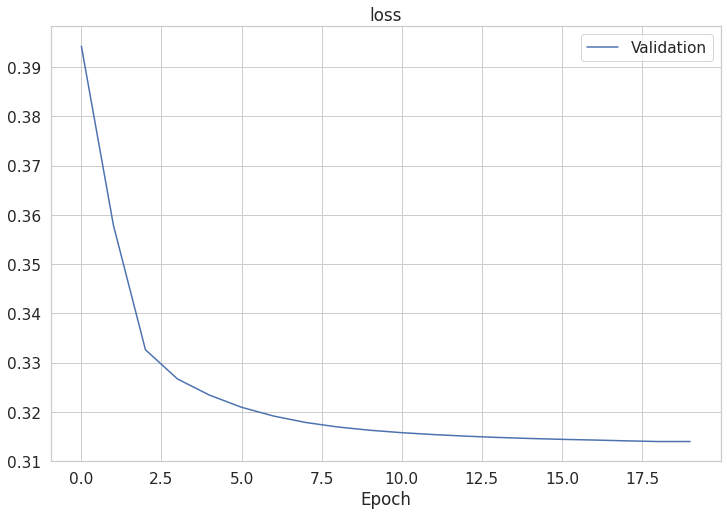

In [60]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses) ), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [61]:
test_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[to_blade:], y_shuffle[to_blade:])), batch_size=n_samples-to_blade)

In [62]:
for X_batch, y_batch in test_dl:
  preds = gru_model(X_batch.to(device))
  break

In [63]:
preds = preds.detach().cpu().numpy()

In [64]:
preds.shape, # preds[:20]

((28038, 2),)

In [65]:
test_auc = roc_auc_score(y_batch, preds[:,1])
test_auc

0.8307323243900625

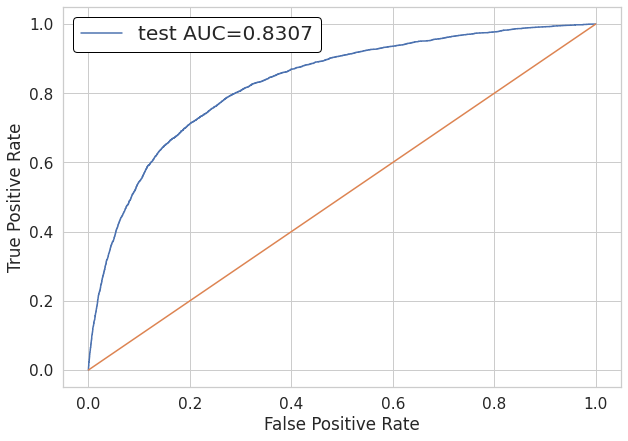

In [66]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,1])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
class RNN(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_x = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_x = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden=None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        seq_length = x.size(1)
        for cur_idx in range(seq_length):
            hidden = torch.tanh(
                x[:, cur_idx] @ self.w_x + self.b_x + hidden @ self.w_h + self.b_h
            )
        return hidden

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.rnn = RNN(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = self.rnn(x)
        hidden = self.cls(hidden)
        return hidden

In [ ]:
num_features = len(list(data_frame))
n_hidden = len(list(data_frame))

rnn_model = RNNModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

num_epochs = 20
max_grad_norm = 1.0

In [ ]:
val_losses = training(rnn_model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm)

In [ ]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses) ), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
for X_batch, y_batch in test_dl:
  preds = rnn_model(X_batch.to(device))
  break

preds = preds.detach().cpu().numpy()

In [ ]:
preds

In [ ]:
test_auc = roc_auc_score(y_batch, preds[:,1])
test_auc

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,1])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
preds.shape